In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsOneClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
train = pd.read_pickle('../data/train.pkl')
test = pd.read_pickle('../data/test.pkl')

### Model selection

In [3]:
vectorizer = TfidfVectorizer()

In [4]:
X_train = vectorizer.fit_transform(train['review_parse'])

In [5]:
X_test = vectorizer.transform(test['review_parse'])

In [6]:
y_train = train['Rating']
y_test = test['Rating']

In [7]:
models = [
    RandomForestClassifier(random_state=SEED),
    LinearSVC(random_state=SEED),
    MultinomialNB(),
    LogisticRegression(random_state=SEED),
]

In [8]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(OneVsOneClassifier(model), X_train, y_train, scoring='accuracy', cv=5)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

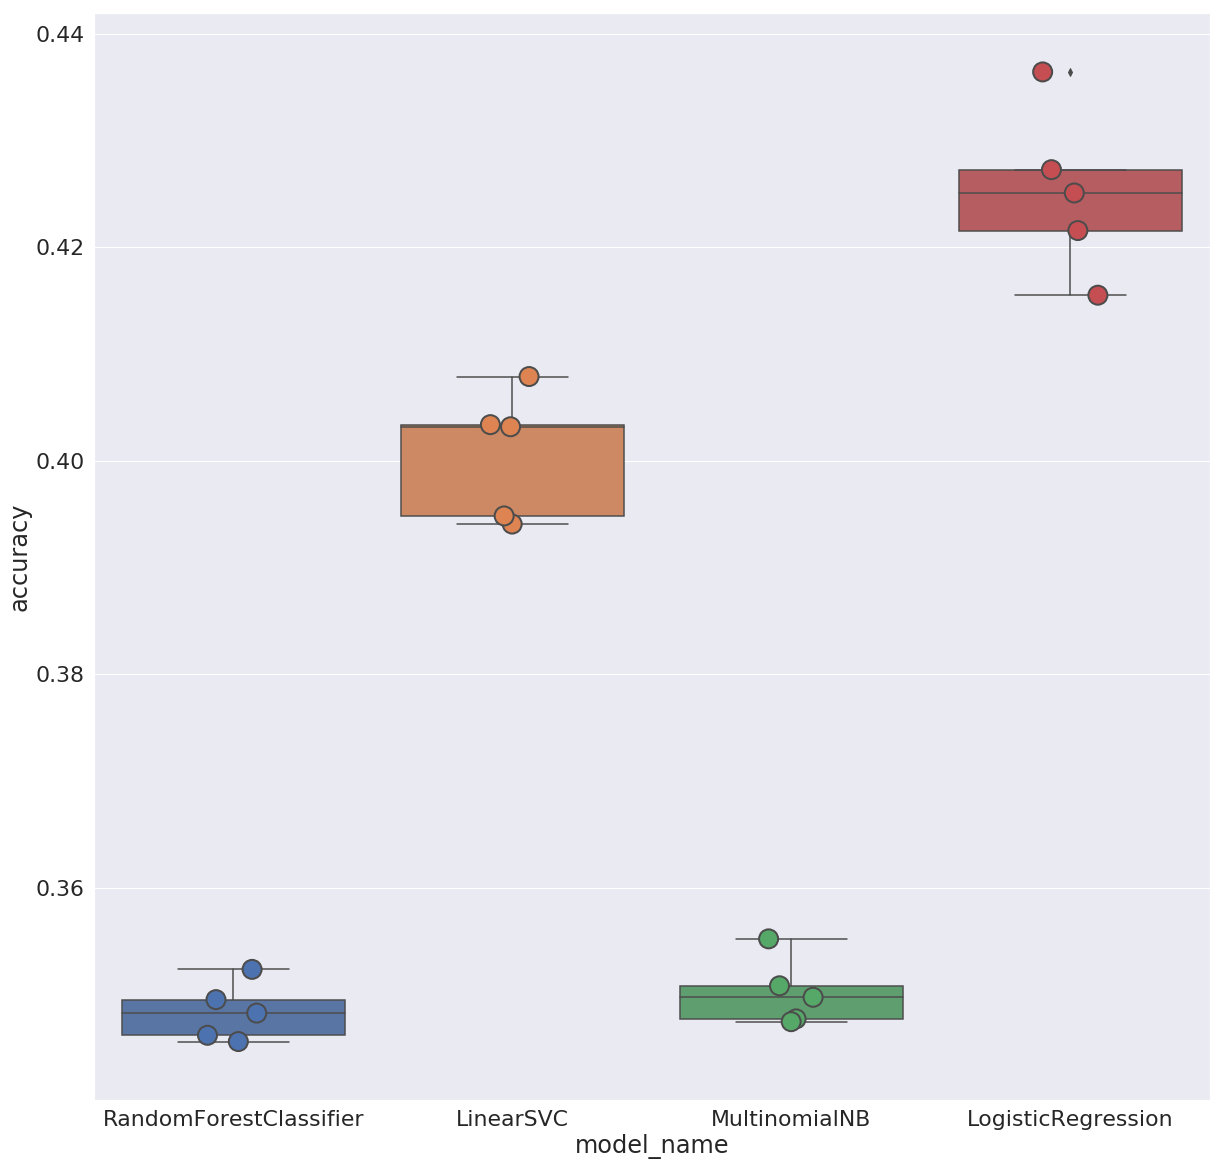

In [9]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=19, jitter=True, edgecolor="gray", linewidth=2, ax=ax)
plt.show()
# fig.savefig('../images/cv.png', bbox_inches = 'tight', pad_inches = 0)

### Training model

In [13]:
vectorizer = TfidfVectorizer(max_df=0.95)

In [14]:
X_train = vectorizer.fit_transform(train['review_parse'])

In [15]:
X_test = vectorizer.transform(test['review_parse'])

In [16]:
y_train = train['Rating']
y_test = test['Rating']

In [17]:
model = OneVsOneClassifier(LogisticRegression(C=2, penalty='l2', solver='liblinear', random_state=SEED))

In [18]:
model.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(C=2, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   n_jobs=None)

In [19]:
y_pred = model.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.80      0.64      4948
           2       0.23      0.07      0.10      2280
           3       0.26      0.13      0.18      2514
           4       0.31      0.34      0.32      2619
           7       0.31      0.23      0.27      2295
           8       0.26      0.25      0.26      2841
           9       0.20      0.04      0.07      2339
          10       0.48      0.75      0.59      4965

    accuracy                           0.42     24801
   macro avg       0.32      0.33      0.30     24801
weighted avg       0.36      0.42      0.37     24801



In [21]:
cmatrix = confusion_matrix(y_test, y_pred)

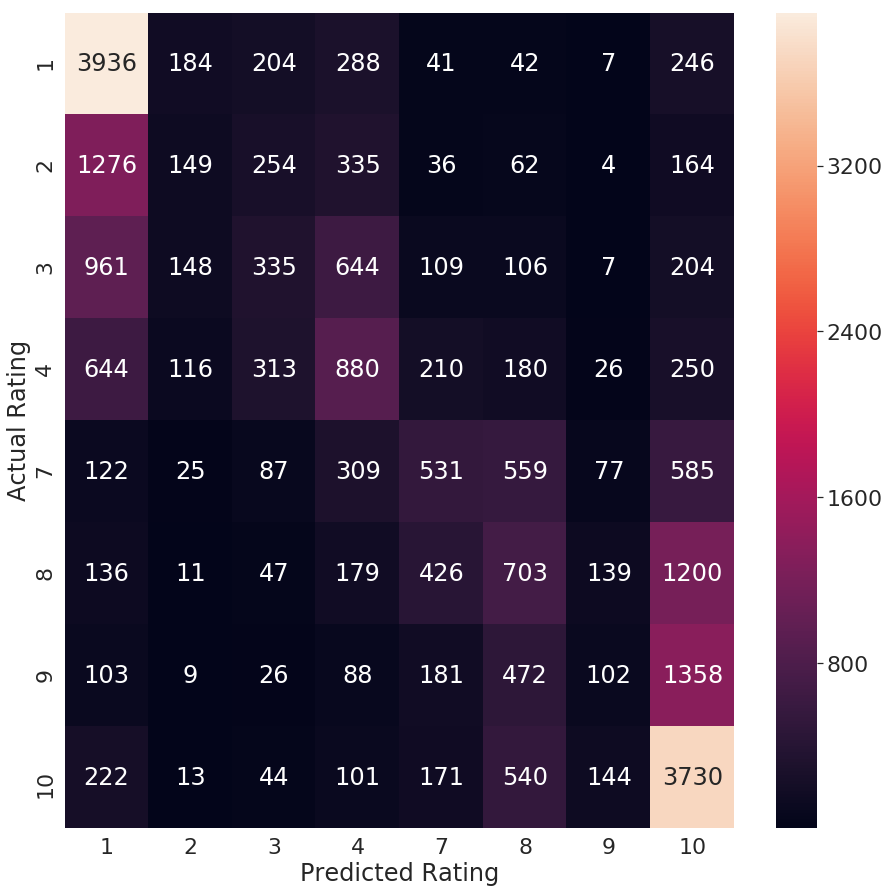

In [22]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmatrix, annot=True, fmt='d', xticklabels=[1,2,3,4,7,8,9,10], yticklabels=[1,2,3,4,7,8,9,10])
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.show()
# fig.savefig('../images/cmatrix.png', bbox_inches = 'tight', pad_inches = 0)

In [14]:
with open('../model/model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
with open('../model/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)